In [1]:
import os
import glob
from functools import reduce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pathlib

import ReadParameterFile

In [2]:
params = ReadParameterFile.get_parameter_dict("semiannually-params")

In [3]:
params

{'end_month': '12',
 'end_year': '2017',
 'graph_types': ['positive', 'negative', 'overall'],
 'input_dir': '../temp',
 'languages': ['english', 'chinese', 'mix'],
 'leader_different': ['lim kit siang',
  'lim guan eng',
  'anwar',
  'mahathir',
  'abdul hadi awang',
  'liow tiong lai',
  'subramaniam',
  'najib'],
 'leader_same_bn': ['liow tiong lai',
  'subramaniam',
  'najib',
  'mah siew keong'],
 'leader_same_pakatan': ['lim kit siang',
  'lim guan eng',
  'anwar',
  'mahathir',
  'abdul hadi awang'],
 'output_dir': '../results',
 'party_different': ['dap', 'pkr', 'ppbm', 'pas', 'mca', 'umno', 'mic'],
 'party_same_bn': ['mca', 'mic', 'umno', 'pbb', 'gerakan'],
 'party_same_pakatan': ['dap', 'pkr', 'pas', 'ppbm', 'amanah'],
 'start_month': '7',
 'start_year': '2017'}

In [4]:
# Extracted from : https://stackoverflow.com/a/2186555
def list_all_files(root_path, ext=".csv", front="20"):
    cfiles = []
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.startswith(front) and file.endswith(ext):
                cfiles.append(os.path.join(root, file))
    return cfiles

In [5]:
def split_files_by_keyword(files, keyword):
    groups = {}
    for kw in keyword:
        groups[kw] = [f for f in files if kw in f]
    return groups
            

In [6]:
def filter_files_by_time_range(files, start_year=2017, end_year=2017, start_month=7, end_month=12):
    # transform args to int as keepsafe
    start_year = int(start_year)
    end_year = int(end_year)
    start_month = int(start_month)
    end_month = int(end_month)
    
    dates = []
    if start_year == end_year:
        dates = [str(start_year) + "_{:02d}".format(n) for n in range(start_month, end_month + 1)]
    return split_files_by_keyword(files, dates)

In [7]:
def flatten_dict(d):
    ret = []
    for k in d:
        ret = ret + d[k]
    return ret

In [8]:
"""
files : array of files

overall is default behavior
"""
def aggregate_tables(files, positive=False, negative=False):
    ret_dict = {}
    for f in files:
        df = pd.read_csv(f, sep=',')
        # Add all names into dict
        for n in set(df['name'].tolist()):
            # Do overall 
            if n in ret_dict:
                ret_dict[n]['overall'] += df.loc[df['name']==n].as_matrix()[0][2:] + df.loc[df['name']==n].as_matrix()[1][2:]
            if n not in ret_dict:
                ret_dict[n] = {'overall': df.loc[df['name']==n].as_matrix()[0][2:] + df.loc[df['name']==n].as_matrix()[1][2:]}
            if positive:
                if "positive" in ret_dict[n]:
                    ret_dict[n]['positive'] += df.loc[(df['name']==n) & (df['scale']==1)].as_matrix()[0][2:]
                else:
                    ret_dict[n]['positive'] = df.loc[(df['name']==n) & (df['scale']==1)].as_matrix()[0][2:]

            if negative:
                if "negative" in ret_dict[n]:
                    ret_dict[n]['negative'] += df.loc[(df['name']==n) & (df['scale']==2)].as_matrix()[0][2:]
                else:
                    ret_dict[n]['negative'] = df.loc[(df['name']==n) & (df['scale']==2)].as_matrix()[0][2:]

    return ret_dict
                

In [9]:
"""
arr : np.array

returns an array of 5 values --> 5 weeks
"""
def summarize_values_to_week(arr):
    return [arr[0:7].sum(), arr[7:14].sum(), arr[14:21].sum(), arr[21:28].sum(), arr[28:31].sum()]

In [10]:
"""
marr : array of dicts

"""
def flatten_map(marr):
    ret_dict = []
    for key in marr[0]:
        new_dict = {key: []}
        for d in marr:
            new_dict[key] += [d[key]]
        ret_dict += [new_dict]
    return ret_dict

In [11]:
def flatten_inner_array(x):
    for i, n in enumerate(x):
        x[i][list(n.keys())[0]] = flatten_map(x[i][list(n.keys())[0]])
        for j, n2 in enumerate(x[i][list(n.keys())[0]]):
            x[i][list(n.keys())[0]][j][list(n2.keys())[0]] = np.concatenate(n2[list(n2.keys())[0]]).ravel().tolist()
    return x

In [12]:
def flatten_array_to_map(marr):
    dict_merge = lambda a,b: a.update(b) or a
    return reduce((lambda x, y: dict_merge(x, y)), marr)

In [17]:
prep_data_cache = None
def prepare_data_from_source(input_dir, languages, pref_language, candidate, graph_types, filters=None, clear_cache=False):
    global prep_data_cache
    if clear_cache:
        prep_data_cache = None
    if not prep_data_cache:
        files = list_all_files(input_dir)
        g = split_files_by_keyword(files, languages)
        d = split_files_by_keyword(g[pref_language], [candidate])
        d = filter_files_by_time_range(d[candidate])
        tables = [aggregate_tables(d[k], positive=True, negative=True) for k in d]
        for _t in tables:
            for k in _t:
                for types in graph_types:
                    _t[k][types] = summarize_values_to_week(_t[k][types])

        x = flatten_map(tables)

        x_last = flatten_inner_array(x)
        xl2 = x_last
        xl3 = flatten_array_to_map(xl2)

        for n in xl3:
            xl3[n] = flatten_array_to_map(xl3[n])

        if filters:
            filtered_dict = flatten_array_to_map([{n: xl3[n]} for n in filters])
        else:
            filtered_dict = flatten_array_to_map([xl3])
        prep_data_cache = filtered_dict    
    else:
        if filters:
            filtered_dict = flatten_array_to_map([{n: prep_data_cache[n]} for n in filters])
        else:
            filtered_dict = flatten_array_to_map([prep_data_cache])
    return filtered_dict

def clear_prep_data_cache():
    global prep_data_cache
    prep_data_cache = None

In [14]:
filtered_dict = prepare_data_from_source(params['input_dir'], params['languages'], 'english', 'leader', params['graph_types'], params['leader_different'])
#filtered_dict = prepare_data_from_source(params['input_dir'], params['languages'], 'english', 'leader', params['graph_types'])
print(filtered_dict)

{'lim kit siang': {'overall': [2, 3, 2, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'positive': [2, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'negative': [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'lim guan eng': {'overall': [2, 7, 3, 5, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'positive': [2, 3, 2, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'negative': [0, 4, 1, 4, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'anwar': {'overall': [8, 21, 26, 13, 5, 4, 5, 0, 10, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'positive': [4, 12, 16, 9, 1, 3, 3, 0, 5, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'negative': [4, 9, 10, 4, 4, 1, 2, 0, 5, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, 'mahathir':

In [25]:
def plot_semiannual_graph(name, data, category="leader_same", plot_kind="overall", save=False, show=True):
    weeks = [i + 1 for i in range(0, 6 * 5)]
    dpi = 96
    plt.figure(figsize=(1366/dpi,768/dpi), dpi=dpi)
    plt.gca().set_color_cycle(['green', 'red', 'blue', 'purple', 'yellow', 'gray', 'orange', 'magenta'])
    
    plt.xlabel("Week")
    plt.ylabel("Polarity")
    plt.xticks(weeks, ["W" + str((i % 5 + 1)) if i % 5 == 1 else str((i % 5 + 1)) for i in weeks])
    
    graph_title = name + " " + plot_kind
    
    plt.suptitle(graph_title, fontsize=20)
    print(len(list(data.keys())))
    for n in data:
        plt.plot(weeks, data[n][plot_kind], label=n)
        
    plt.legend()
    
    if save:
        root_dir = params['output_dir']
        graph_dir = "semiannual_plot"
        current_run_dir = params['start_year'] + "-" + params['start_month'] + "__" + params['end_year'] + "-" + params['end_month']
        endpath = os.path.join(root_dir, graph_dir, current_run_dir)
        
        pathlib.Path(endpath).mkdir(parents=True, exist_ok=True)
        plt.savefig(os.path.join(endpath, category + "_" + plot_kind + ".png"), dpi=dpi)
        
    if show:
        plt.show()
    
    plt.clf()
    

/usr/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


8


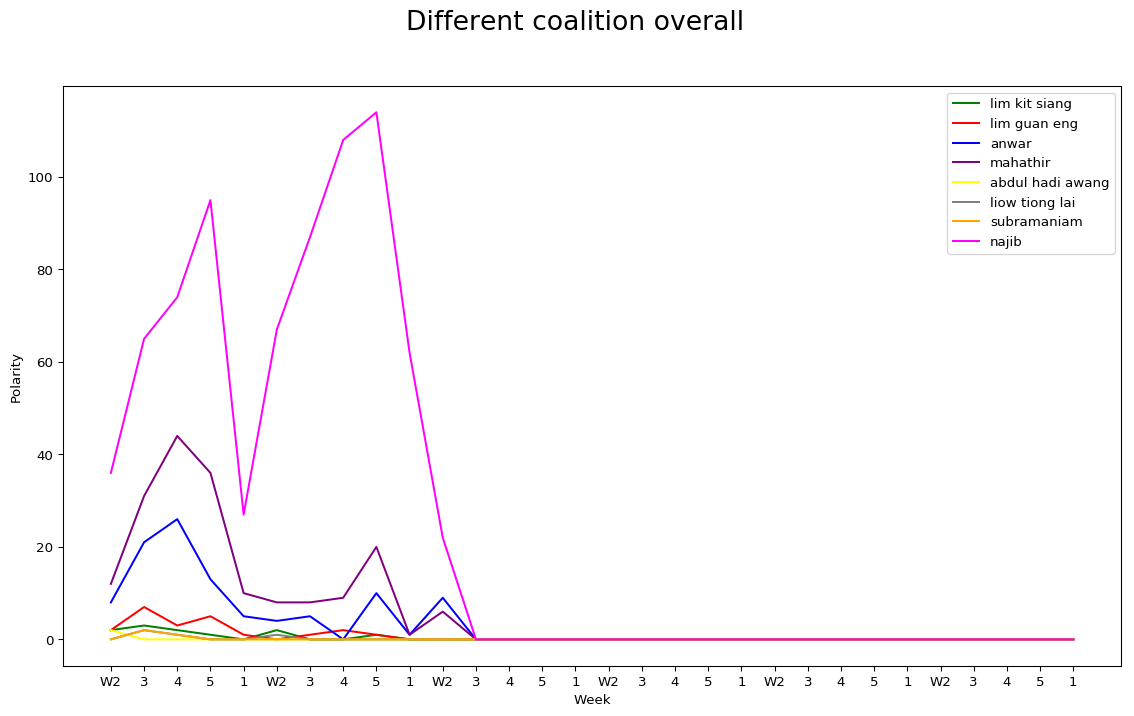

8


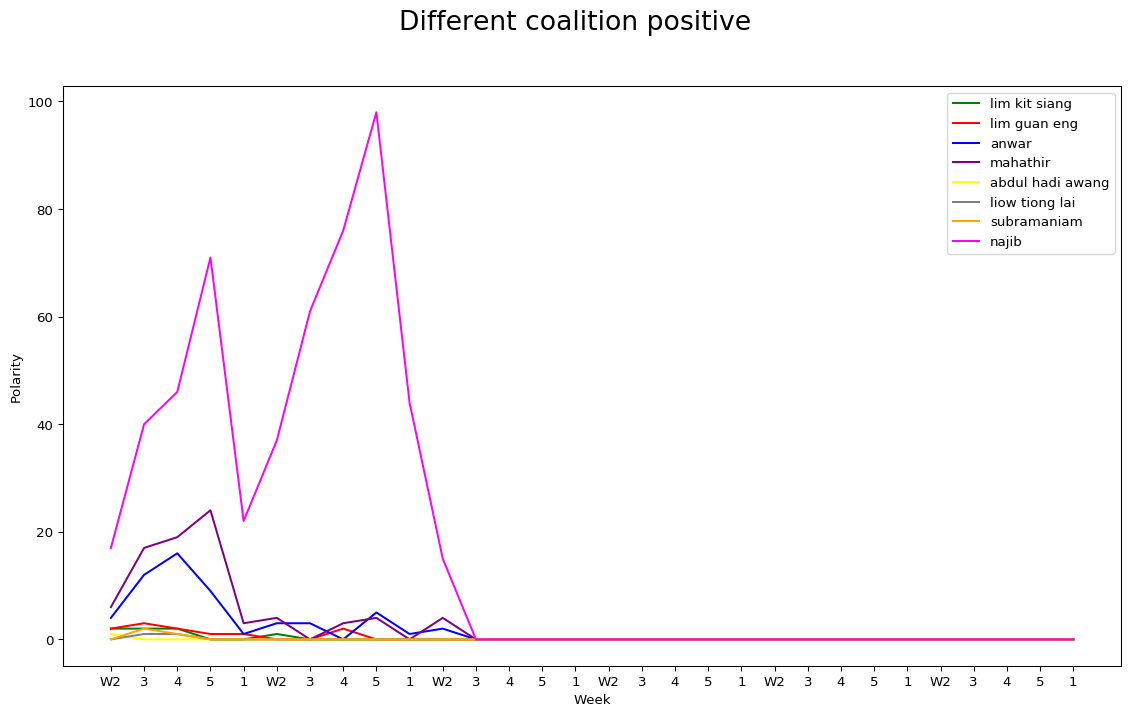

8


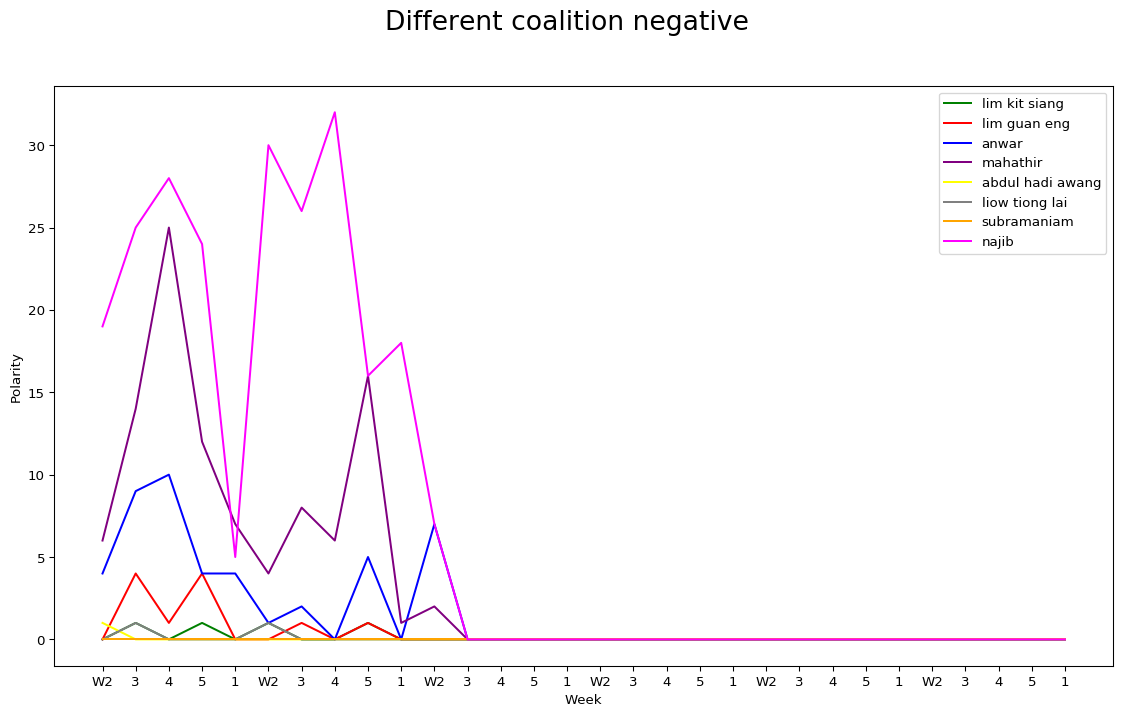

In [26]:
plot_semiannual_graph("Different coalition", filtered_dict, save=True)
plot_semiannual_graph("Different coalition", filtered_dict, plot_kind="positive", save=True)
plot_semiannual_graph("Different coalition", filtered_dict, plot_kind="negative", save=True)